In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
%matplotlib inline

In [6]:
# ** Set up a plotting function ** #

def plotting(U,x,t, exact_handle):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver']    
    
    # choose some (almost arbitrary) display times
    disp_times = [0, N//20, N//10, N//5, N//2, N]              

    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Dummy plot for legend titles
    ax.scatter([0], [0], color='white', label=r'Exact $u(x,t)$', lw=0)

    # Plot actual curves
    for i, idx_t in enumerate(disp_times):
        label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
        ax.plot(x, exact_handle(x,t[idx_t]), color = colours[i], label = label)

    ax.scatter([0], [0], color='white', label=r'Numerical $U(x,t)$', lw=0)
    for i, idx_t in enumerate(disp_times):
        label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )

    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5), title ='Comparison')
    ax.set_xlim(0-1e-2,1.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Solution")
    plt.show()

dx = 1.00e-02, dt = 5.00e-03, C = 50.0


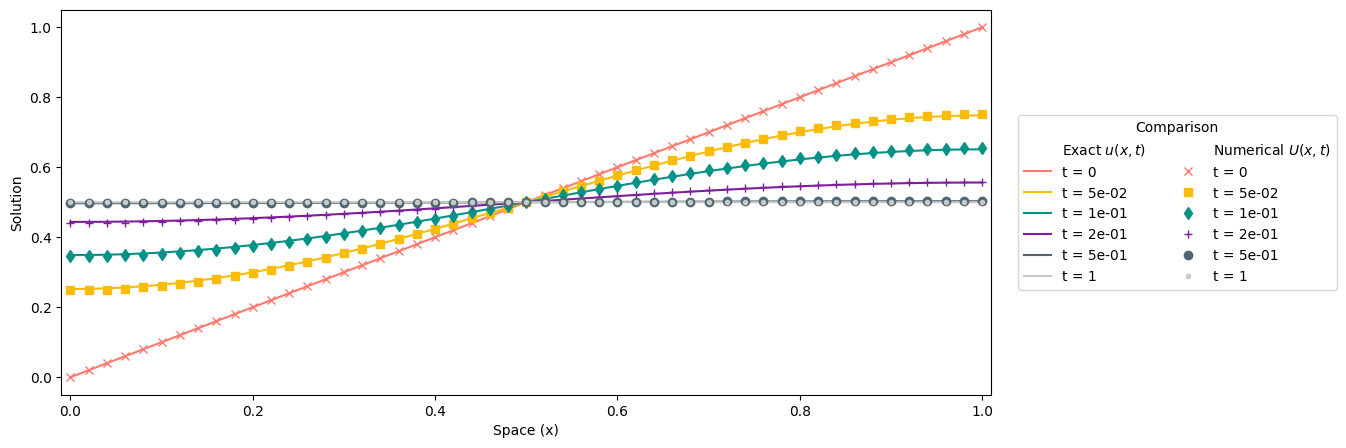

In [7]:
# ** Initial condition ** #
def f(x):    
    return x

# ** Exact solution ** #
def U_exact(x,t, K = 2000):
    ''' 
        Computes the 'exact' solution u(x,t) of (4.b)
        ––––––
        Input:
            x: a numpy array discretising [0,1]
            t: a real number in [0,T]
            K: number of nonzero Fourier coefficients
    '''

    # start with the constant part
    u_exact = 0.5*np.ones_like(x)
        
    # ** Sum K terms of the Fourier representation **
    # Note that we only need to include the even terms
    for k in range(1,K,2):
        kpi= k*np.pi
        c_k = -(4.0)/(kpi**2)
        u_exact = u_exact + c_k * np.cos(kpi*x) * np.exp(-1 * kpi**2 * t)
    
    return u_exact

# ** Set parameters ** #
N = 200      # number of timesteps
T = 1.0      # final time 
t = np.linspace(0.0, T, N + 1)      # Time grid

M = 100    # number of spaces in x
x = np.linspace(0.0, 1.0, M + 1)    # Space grid

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)
print('dx = {0:.2e}, dt = {1:.2e}, C = {2}'.format(dx, dt, C))

# Store data in sparse format to prevent the memory allocation of M² - M + 2 zeros

# Values on the three non-zero diagonals
diags = np.ones((3,M+1))

# Add 2C to main diagonal (first index = 0 represents the main diagonal here)
diags[0] += 2 * C             

# The upper and lower diagonals are -C except in the first/last row, which we will deal with next
diags[1:] = - C;    

# Fix the upper diagonal in the first row (the first entry should be -2C)
diags[1,0] = - 2*C

# Fix the lower diagonal in the last row (the penultimate entry should be -2C - the last is ignored when making A)
diags[2,-2] = -2*C

# Create the matrix, taking care of the order in which we defined the diagonals
# format = 'csr' defines a sparse matrix
A = diags_array(diags, offsets = (0,1,-1), shape = (M+1, M+1), format = 'csr')

# ** Initialize output ** #

# Preallocate the numerical solution in a matrix: the first dimension is time and the second is space; i.e., each row corresponds to a timestep
U = np.zeros((N+1,M+1))
U[0] = f(x)

# Also store numerical solution
U_ex = np.zeros((N+1,M+1))

# ** Iterate ** #
for n in range(0, N):
    # Solve linear system instead of computing the inverse: computing the inverse is expensive and numerically instable 
    # SciPy has a subroutine for sparse matrices, but if you want to stick to NumPy, you can instead use: np.linalg.solve(A.toarray(),U[0])
    U[n+1] = spsolve(A, U[n])
    U_ex[n] = U_exact(x,t[n])
    
U_ex[n+1] = U_exact(x,t[n+1])

# Feel free to compare the solution as in the first bit of the notebook:
plotting(U,x,t, U_exact)